# QUORA INSINCERE QUESTIONS CLASSIFICATION - COMPETITION

# The objective is to predict whether a question asked on Quora is sincere or not.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora/sample_submission.csv
/kaggle/input/quora/test.csv
/kaggle/input/quora/train.csv


In [2]:
#!pip install gensim
!pip install emot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Packages installed

1) nltk

2) pyspellchecker

3) gensim

4) emot

In [3]:
# Importing libraries

import os
import json
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import nltk
import operator 
import re
import gc
import keras
import gensim
import re

from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from tqdm import tqdm
tqdm.pandas()
from pandas import Panel

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version


**LOADING THE DATA**

This task constitutes of two datasets: (i) Training data: This dataset will be used for training the model to classify the quora questions into sincere and insincere (ii) Test data: This dataset will be used to validate the predictability of the model constructed using the training set.

In [4]:
# Loading the training data

qiq_trn = pd.read_csv("/kaggle/input/quora/train.csv")
print("Number of texts: ", qiq_trn.shape[0])

Number of texts:  783673


In [5]:
# Glimpse of the training data
qiq_trn.head(10)

,qid,question_text,target
0,6f47b0f60633c2056455,"How can I reply to this comment, ""India is poo...",0
1,d49b3966070b27bf07fc,What did they use for transportation in Ancien...,0
2,6d5faa49380557c8ca7b,What are the most important provisions of Obam...,0
3,cebea75faa47388edcf5,At what age do most Finns master English today?,0
4,2a7b76a679cadb0a016e,What is cheapest place to live in India for on...,0
5,b2704fa0f4fbf2a3d1ca,What are the bubbles coming from the lake?,0
6,aaa89e7ff7b80d0c7055,Is living your life through your own philosoph...,0
7,9863af25f17e29846aed,Why do girls become escorts or sex workers?,1
8,c71b309d3acd89f3ec59,How tall is Kay Aull?,0
9,f4d51d62d4cf812cb001,What is the largest life form with an exoskele...,0


In [6]:
# Loading the test data

qiq_tst = pd.read_csv("/kaggle/input/quora/test.csv")
print("Number of texts: ", qiq_tst.shape[0])

Number of texts:  522449


In [7]:
# Glimpse of the test data
qiq_tst.head(10)

,qid,question_text
0,f56a9a31974dc66186e8,Is it a good idea to go through a phlebotomy c...
1,d957c3758060f45da303,How can I fix a lead into a camlin compass to ...
2,ad822d5abaedb9e247b9,How many animes are there in world?
3,4e979c23eeb6a4bd1f2e,How do I tell my family I cut?
4,333cc031262566b8da49,How do I save down my bitcoin image address fr...
5,72421eb3dae324c79a19,How do I one-up people in arguments without re...
6,6bc6303e0ba6b0d145aa,What are some natural remedies for sharp pain ...
7,d31485e4bd5542e34a09,What are some good places that dye dresses in ...
8,7fe49e0eacbbb2504576,Can we actually reduce cost and improve speed ...
9,0a1adadf7a8e43496a17,"Aside from the ""Barcelona-PSG"" match in 2017 a..."


In [8]:
# Basic Info about the training and test datasets
qiq_trn.info()
print("\n\n")
qiq_tst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783673 entries, 0 to 783672
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            783673 non-null  object
 1   question_text  783673 non-null  object
 2   target         783673 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 17.9+ MB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522449 entries, 0 to 522448
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   qid            522449 non-null  object
 1   question_text  522449 non-null  object
dtypes: object(2)
memory usage: 8.0+ MB


The training set constituted 783673 entries and the test set constitute of 522449 entries. The training set also constitutes a binary coded target column, which is distinguishes insincere questions from sincere questions.

In [9]:
# Checking for null values in training and test sets
print("Null values in training set ")
print(qiq_trn.isna().sum())
print("\n\n")
print("Null values in test set ")
print(qiq_tst.isna().sum())

Null values in training set 
qid              0
question_text    0
target           0
dtype: int64



Null values in test set 
qid              0
question_text    0
dtype: int64


It is noted that both the datasets - training and test have no null values

In [10]:
# Checking for duplicates
print("Screening the datasets for duplicate values")
print("Training dataset")
print(qiq_trn.duplicated().sum())
print("\n")
print("Test dataset")
print(qiq_tst.duplicated().sum())

Screening the datasets for duplicate values
Training dataset
0


Test dataset
0


Since the data has no NaN values, data can be considered for further processing. Here on, training set will only be used for exploratory data analysis

**TRAINING DATASET**

In [11]:
# Calculating the total sincere and insincere questions in training dataset
trn_sin_q = (qiq_trn['target'] == 0).sum()
trn_insin_q = (qiq_trn['target'] == 1).sum()

print("Total sincere questions in the training dataset:", trn_sin_q)
print("Total insincere questions in the training dataset:", trn_insin_q)

Total sincere questions in the training dataset: 735222
Total insincere questions in the training dataset: 48451


In [12]:
# Percentage of sincere and insincere questtions in the datasets

trn_percent_sin_q = (trn_sin_q/(trn_sin_q + trn_insin_q)*100)
trn_percent_insin_q = (trn_insin_q/(trn_sin_q + trn_insin_q)*100)

print( '{}% are sincere and {}% are insincere questions in training dataset'.format(trn_percent_sin_q, trn_percent_insin_q))

93.81744681774158% are sincere and 6.182553182258417% are insincere questions in training dataset


Text(0, 0.5, 'Percentage')

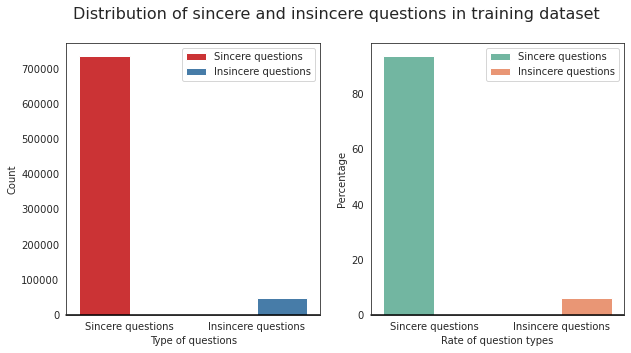

In [13]:
# Distribution of the type of questions in the training dataset

trn_Ques = [trn_sin_q, trn_insin_q]
trn_Ques_percent = [trn_percent_sin_q, trn_percent_insin_q]


# Set up the matplotlib figure
sns.set_style('white')
sns.color_palette("Set2")
# Barplot for the count of the type of questions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

plt.suptitle('Distribution of sincere and insincere questions in training dataset', fontsize=16)

x = ['Sincere questions','Insincere questions']
y = trn_Ques
sns.barplot(x=x, y=y, ax=ax1, palette="Set1", hue = x)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_xlabel("Type of questions")
ax1.set_ylabel("Count")

# Pieplot for the rate of type of questions

x = ['Sincere questions','Insincere questions']
y = trn_Ques_percent
sns.barplot(x=x, y=y, ax=ax2, palette="Set2", hue = x)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_xlabel("Rate of question types")
ax2.set_ylabel("Percentage")

# EXPLORATORY DATA ANALYSIS (EDA)

Performing EDA of training set before data curation

In [14]:
# Creating an empty dataframe to add the feature extracted columns from the training dataset
trn_eda = pd.DataFrame(qiq_trn["target"])
# Computing the frequency of questions
trn_eda['freq_qid'] = qiq_trn.groupby('qid')['qid'].transform('count')
#Computing the length of the questions
trn_eda['qlen'] = qiq_trn['question_text'].str.len() 
# Enumerating words
trn_eda['n_words'] = qiq_trn['question_text'].apply(lambda i: len(str(i).split()))
# Enumerating capital_letters
trn_eda['n_caps'] = qiq_trn['question_text'].apply(lambda i: len([c for c in str(i) if c.isupper()]))
# Enumerating the special characters
trn_eda['n_spl_char'] = qiq_trn['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
# Enumerating unique words
trn_eda['n_uniq_words'] = qiq_trn['question_text'].apply(lambda i: len(set(str(i).split())))
# Enumerating numerics
trn_eda['n_nums'] = qiq_trn['question_text'].apply(lambda i: sum(c.isdigit() for c in i))
# Enumerating characters
trn_eda['n_char'] = qiq_trn['question_text'].apply(lambda i: len(str(i)))
# Enumerating stopwords
stop_words = set(stopwords.words('english')) 
trn_eda['n_stopwords'] = qiq_trn['question_text'].apply(lambda i: len([c for c in str(i).lower().split() if c in stop_words]))

In [15]:
trn_eda.head(10)

,target,freq_qid,qlen,n_words,n_caps,n_spl_char,n_uniq_words,n_nums,n_char,n_stopwords
0,0,1,137,24,9,8,22,0,137,13
1,0,1,54,9,3,1,9,0,54,5
2,0,1,52,8,2,1,8,0,52,5
3,0,1,47,9,3,1,9,0,47,4
4,0,1,88,17,2,1,16,0,88,7
5,0,1,42,8,1,1,7,0,42,5
6,0,1,112,20,1,1,18,0,112,10
7,1,1,43,8,1,1,8,0,43,3
8,0,1,21,5,3,1,5,0,21,2
9,0,1,50,9,1,1,9,0,50,5


Plotting the total counts of various features in training data

In [16]:
trn_count = trn_eda.groupby(["target"]).sum().reset_index()

Count plot of the various features of the training dataset categorised into sincere and insincere questions

In [17]:
trn_count

,target,freq_qid,qlen,n_words,n_caps,n_spl_char,n_uniq_words,n_nums,n_char,n_stopwords
0,0,735222,50639815,9197481,2064326,1277431,8732776,271679,50639815,4441910
1,1,48451,4760549,838942,177385,120177,778595,12339,4760549,388435


In [18]:
Cols = list(trn_count.columns)

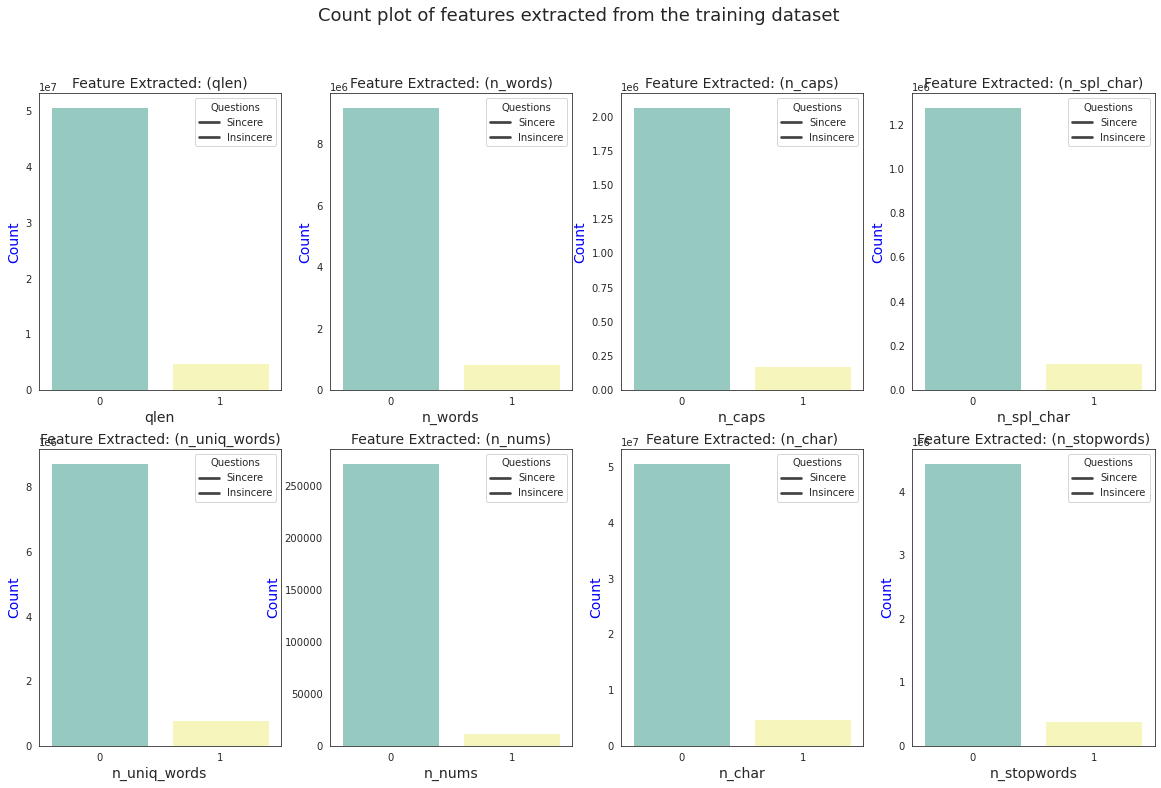

In [19]:
# Set up the matplotlib figure

# Initialize the figure 
fig = plt.figure(figsize=(20, 12))
nrows = 2
ncols = 4
plt.suptitle("Count plot of features extracted from the training dataset", fontsize = 18)

for i in range(2, len(Cols)):
    col = Cols[i]
    plt.subplot(nrows, ncols, i-1)
    plt.title('Feature Extracted: ({})'.format(col), fontsize=14)
    ax = sns.barplot(x="target", y=col, data=trn_count, palette="Set3")
    ax.set_xlabel(xlabel=col, size=14)
    ax.set_ylabel(ylabel='Count' , color='b', size=14)
    plt.legend(title='Questions', loc='best', labels=['Sincere', 'Insincere'])

Distribution of the text features extracted from the training dataset

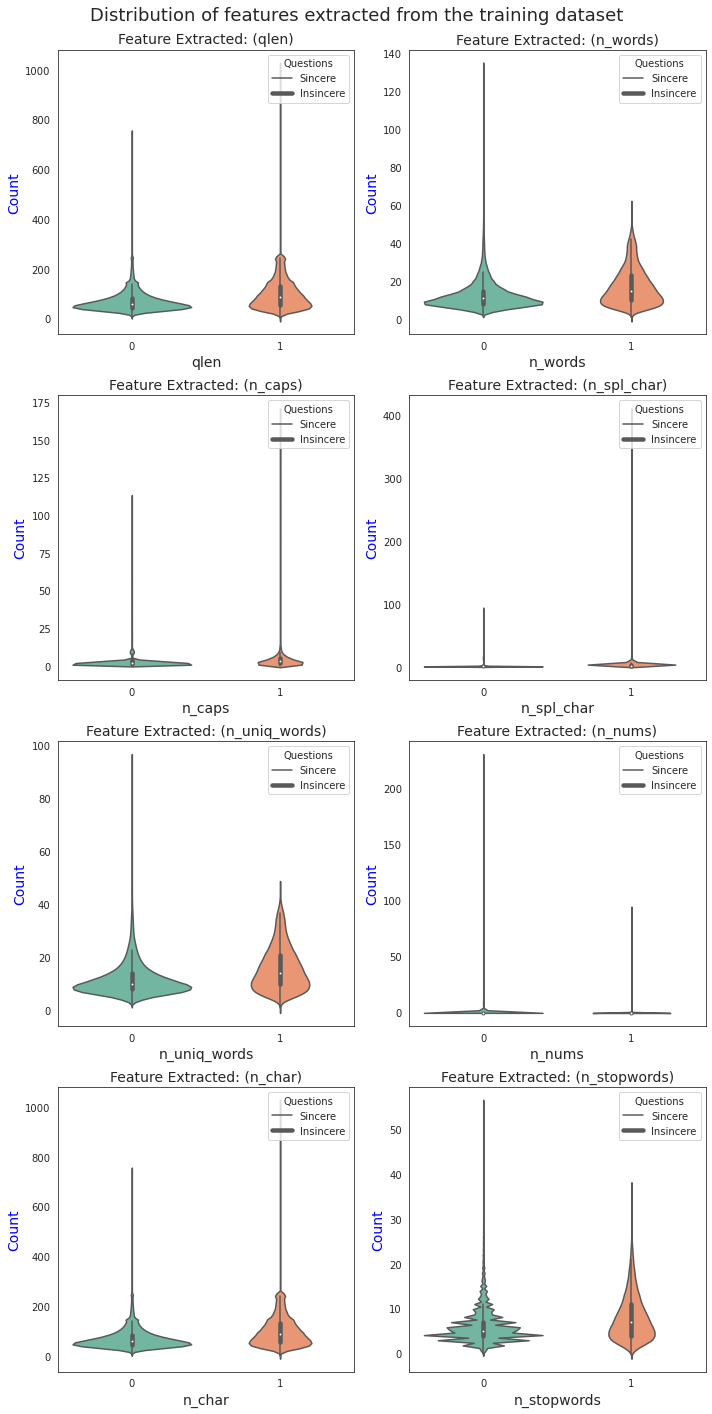

In [20]:
# Violin plot of features extracted 

Cols = list(trn_eda.columns)

# Initialize the figure 
fig = plt.figure(figsize=(10, 20))
nrows = 4
ncols = 2
plt.suptitle("Distribution of features extracted from the training dataset", fontsize = 18)
for i in range(2, len(Cols)):
    col = Cols[i]
    plt.subplot(nrows, ncols, i-1)
    plt.title('Feature Extracted: ({})'.format(col), fontsize=14)
    ax = sns.violinplot(x="target", y=col, data=trn_eda, palette="Set2")
    ax.set_xlabel(xlabel=col, size=14)
    ax.set_ylabel(ylabel='Count' , color='b', size=14)
    plt.legend(title='Questions', loc='best', labels=['Sincere', 'Insincere'])
      
fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)


The above violin plots show the distribution of length of questions (qlen), count of words (n_words), capital letters (n_caps), special characters (n_spl_char), unique words (n_uniq_words), numbers (n_nums), characters (n_chars) and stopwords (n_stopwords) in both the question types classified as sincere and insincere questions of the training dataset.

It is noted that the counts in the sincere and insincere questions had same median but their distributions varied, as the latter showing more spread out distribution of the counts than the former.

Hence, text cleaning has to be performed before processing the data

In [21]:
# Creating an empty dataframe to add the feature extracted columns from the training dataset
tst_eda = pd.DataFrame()
# Computing the frequency of questions
tst_eda['freq_qid'] = qiq_tst.groupby('qid')['qid'].transform('count')
#Computing the length of the questions
tst_eda['qlen'] = qiq_tst['question_text'].str.len() 
# Enumerating words
tst_eda['n_words'] = qiq_tst['question_text'].apply(lambda i: len(str(i).split()))
# Enumerating capital_letters
tst_eda['n_caps'] = qiq_tst['question_text'].apply(lambda i: len([c for c in str(i) if c.isupper()]))
# Enumerating the special characters
tst_eda['n_spl_char'] = qiq_tst['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
# Enumerating unique words
tst_eda['n_uniq_words'] = qiq_tst['question_text'].apply(lambda i: len(set(str(i).split())))
# Enumerating numerics
tst_eda['n_nums'] = qiq_tst['question_text'].apply(lambda i: sum(c.isdigit() for c in i))
# Enumerating characters
tst_eda['n_char'] = qiq_tst['question_text'].apply(lambda i: len(str(i)))
# Enumerating stopwords
stop_words = set(stopwords.words('english')) 
tst_eda['n_stopwords'] = qiq_tst['question_text'].apply(lambda i: len([c for c in str(i).lower().split() if c in stop_words]))

In [22]:
tst_eda.head()

,freq_qid,qlen,n_words,n_caps,n_spl_char,n_uniq_words,n_nums,n_char,n_stopwords
0,1,132,26,2,2,24,0,132,13
1,1,89,17,2,2,16,0,89,8
2,1,35,7,1,1,7,0,35,4
3,1,30,8,3,1,7,0,30,5
4,1,58,11,2,1,11,0,58,6


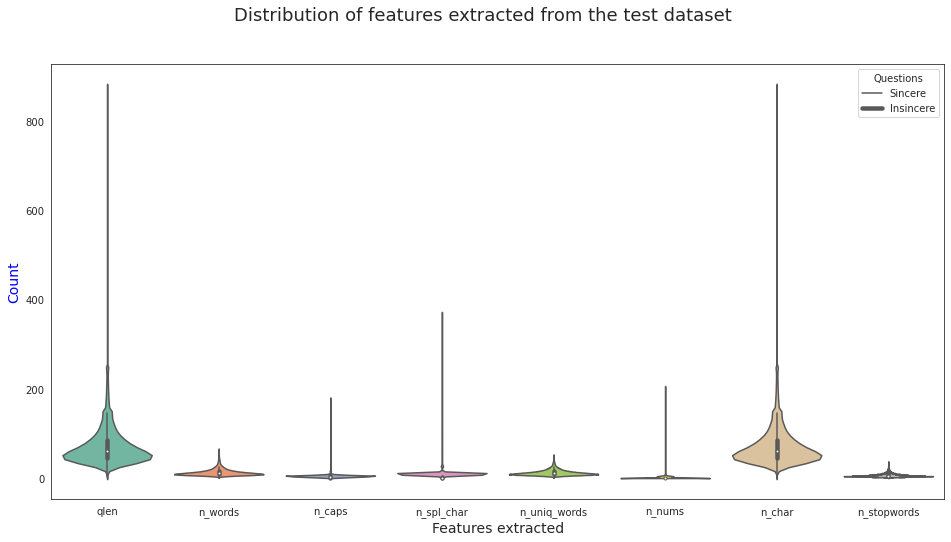

In [23]:
Cols = list(tst_eda.columns)

# Initialize the figure 
df = tst_eda.drop(["freq_qid"], axis = 'columns')
fig = plt.figure(figsize=(16, 8))
plt.suptitle("Distribution of features extracted from the test dataset", fontsize = 18)
ax = sns.violinplot(data=df, palette="Set2", scale="count")
ax.set_xlabel(xlabel='Features extracted', size=14)
ax.set_ylabel(ylabel='Count' , color='b', size=14)
plt.legend(title='Questions', loc='best', labels=['Sincere', 'Insincere'])

The above violin plots represent the distribution of the length of questions (qlen), count of words (n_words), capital letters (n_caps), special characters (n_spl_char), unique words (n_uniq_words), numbers (n_nums), characters (n_chars) and stopwords (n_stopwords) in the training dataset, which are to be classified based on the model generated using the test data.

It is noted that the distributions of counts under various features varies. Since, it is a test data, no preprocessing of text is required.

# DATA PREPARATION

# Text cleaning of the training dataset

Firstly, the questions in the training dataset is tokenized to using Natural Language Toolkit, or NLTK, a Python library written for working and modeling text.

In [24]:
#convert sentences into word(word tokenization)
sentences=qiq_trn["question_text"].values

In [25]:
sentences

array(['How can I reply to this comment, "India is poor. It is a fact. I don\'t understand the unnecessary criticism of Snapchat CEO\'s statement"?',
       'What did they use for transportation in Ancient India?',
       'What are the most important provisions of Obamacare?', ...,
       'How do you prevent having low potassium while pregnant?',
       'What is it like to meet the band Imagine Dragons?',
       "How can I find an intelligent, well reasoned person who can discuss conservative views? It seems most conservatives I know either can't articulate their position or resort to name calling."],
      dtype=object)

Lower Casing

In [26]:
# Removing punctuation marks

PUNCT_TO_REMOVE = string.punctuation
def rmv_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Removing stop words
STOPWORDS = set(stopwords.words('english'))
def rmv_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Removing numbers
def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [27]:
#Feature Engineering on Training Data

df_trn = pd.DataFrame(qiq_trn["qid"])
df_trn["target"] = qiq_trn["target"]
df_trn["lowercase"] = qiq_trn["question_text"].str.lower()
df_trn["no_punct"] = df_trn["lowercase"].apply(lambda text: rmv_punctuation(text))
df_trn["no_stopwords"] = df_trn["no_punct"].apply(lambda text: rmv_stopwords(text))
df_trn["no_num"] = df_trn["no_stopwords"].apply(lambda text: clean_numbers(text))
df_trn.head()

,qid,target,lowercase,no_punct,no_stopwords,no_num
0,6f47b0f60633c2056455,0,"how can i reply to this comment, ""india is poo...",how can i reply to this comment india is poor ...,reply comment india poor fact dont understand ...,reply comment india poor fact dont understand ...
1,d49b3966070b27bf07fc,0,what did they use for transportation in ancien...,what did they use for transportation in ancien...,use transportation ancient india,use transportation ancient india
2,6d5faa49380557c8ca7b,0,what are the most important provisions of obam...,what are the most important provisions of obam...,important provisions obamacare,important provisions obamacare
3,cebea75faa47388edcf5,0,at what age do most finns master english today?,at what age do most finns master english today,age finns master english today,age finns master english today
4,2a7b76a679cadb0a016e,0,what is cheapest place to live in india for on...,what is cheapest place to live in india for on...,cheapest place live india one month best suits...,cheapest place live india one month best suits...


In [28]:
# Saving the dataframe as csv file

df_trn.to_csv('qiq_classification-v1.csv',index=False)

In [29]:
#df_trn['spell_chk'] = df_trn['no_stopwords'].apply(lambda x: str(TextBlob(x).correct()))

In [30]:
#df_trn.to_csv('qiq_classification-v12.csv',index=False)

In [31]:
#def convert_emojis(text):
#    for emot in UNICODE_EMO:
#        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
#    return text

In [32]:
#df_trn["transfrm_emojis"] = df_trn["no_stopwords"].apply(lambda text: convert_emojis(text))
#df_trn

In [33]:
#df_trn.to_csv('qiq_classification-v2.csv',index=False)

In [34]:
df_trn.drop(['lowercase', 'no_punct', 'no_stopwords'], axis = 1, inplace = True)

In [35]:
df_trn

,qid,target,no_num
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...
1,d49b3966070b27bf07fc,0,use transportation ancient india
2,6d5faa49380557c8ca7b,0,important provisions obamacare
3,cebea75faa47388edcf5,0,age finns master english today
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...
...,...,...,...
783668,8462d2ead608fe1dcf9b,0,causes lump back head
783669,12d225a4e28317c02151,0,standalone simple way
783670,03edc045cadbb11558dd,0,prevent low potassium pregnant
783671,c6fb7dc8d0b34160dbe4,0,like meet band imagine dragons


In [36]:
df_trn.columns=['qid', 'target', 'question_text']
df_trn.head(5)

,qid,target,question_text
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...
1,d49b3966070b27bf07fc,0,use transportation ancient india
2,6d5faa49380557c8ca7b,0,important provisions obamacare
3,cebea75faa47388edcf5,0,age finns master english today
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...


In [37]:
# Saving the dataframe as csv file

df_trn.to_csv('qiq_classification_data-clean-v2.csv',index=False)

# Text cleaning of the test dataset

In [38]:
#Feature Engineering on Training Data

df_tst = pd.DataFrame(qiq_tst["qid"])
df_tst["lowercase"] = qiq_tst["question_text"].str.lower()
df_tst["no_punct"] = df_tst["lowercase"].apply(lambda text: rmv_punctuation(text))
df_tst["no_stopwords"] = df_tst["no_punct"].apply(lambda text: rmv_stopwords(text))
df_tst["no_num"] = df_tst["no_stopwords"].apply(lambda text: clean_numbers(text))
df_tst.head()

,qid,lowercase,no_punct,no_stopwords,no_num
0,f56a9a31974dc66186e8,is it a good idea to go through a phlebotomy c...,is it a good idea to go through a phlebotomy c...,good idea go phlebotomy class going nursing sc...,good idea go phlebotomy class going nursing sc...
1,d957c3758060f45da303,how can i fix a lead into a camlin compass to ...,how can i fix a lead into a camlin compass to ...,fix lead camlin compass draw arcs circles engi...,fix lead camlin compass draw arcs circles engi...
2,ad822d5abaedb9e247b9,how many animes are there in world?,how many animes are there in world,many animes world,many animes world
3,4e979c23eeb6a4bd1f2e,how do i tell my family i cut?,how do i tell my family i cut,tell family cut,tell family cut
4,333cc031262566b8da49,how do i save down my bitcoin image address fr...,how do i save down my bitcoin image address fr...,save bitcoin image address coinbase,save bitcoin image address coinbase


# **TOKENIZATION**

In [39]:
def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


df_trn['Tokenized_text'] = df_trn['question_text'].apply(lambda x: tokenize(x.lower()))

df_trn.head(5) 

,qid,target,question_text,Tokenized_text
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...,"[reply, comment, india, poor, fact, dont, unde..."
1,d49b3966070b27bf07fc,0,use transportation ancient india,"[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,0,important provisions obamacare,"[important, provisions, obamacare]"
3,cebea75faa47388edcf5,0,age finns master english today,"[age, finns, master, english, today]"
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...,"[cheapest, place, live, india, one, month, bes..."


# LEMMATIZATION

Lemmatization returns the lemma, which is the root word of all its inflection forms. Lemmatization is a more powerful operation as it takes into consideration the morphological analysis of the word.

In [40]:
wordnet=WordNetLemmatizer()
ps=PorterStemmer()

def lemmatization(tokens):
    text = [wordnet.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return text

In [41]:
df_trn['lemm_text'] = df_trn['Tokenized_text'].apply(lambda x : lemmatization(x))
df_trn.head(5)

,qid,target,question_text,Tokenized_text,lemm_text
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...,"[reply, comment, india, poor, fact, dont, unde...","[reply, comment, india, poor, fact, dont, unde..."
1,d49b3966070b27bf07fc,0,use transportation ancient india,"[use, transportation, ancient, india]","[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,0,important provisions obamacare,"[important, provisions, obamacare]","[important, provision, obamacare]"
3,cebea75faa47388edcf5,0,age finns master english today,"[age, finns, master, english, today]","[age, finn, master, english, today]"
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes..."


In [42]:
df_trn.to_csv('qiq_classification_Lemm-v3.csv',index=False)

Checking the text data after processing

In [43]:
df_trn_eda = pd.DataFrame(df_trn['lemm_text'])
#Adding target column from trn_eda
df_trn_eda['target'] = df_trn['target']
#Computing the length of the questions
df_trn_eda['qlen'] = df_trn['lemm_text'].str.len() 
# Enumerating words
df_trn_eda['n_words'] = df_trn['lemm_text'].apply(lambda i: len(str(i).split()))
# Enumerating capital_letters
df_trn_eda['n_caps'] = df_trn['lemm_text'].apply(lambda i: len([c for c in str(i) if c.isupper()]))
# Enumerating the special characters
#df_trn_eda['n_spl_char'] = df_trn['lemm_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
# Enumerating unique words
df_trn_eda['n_uniq_words'] = df_trn['lemm_text'].apply(lambda i: len(set(str(i).split())))
# Enumerating numerics
df_trn_eda['n_nums'] = df_trn['lemm_text'].apply(lambda i: sum(c.isdigit() for c in i))
# Enumerating characters
df_trn_eda['n_char'] = df_trn['lemm_text'].apply(lambda i: len(str(i)))
# Enumerating stopwords
stop_words = set(stopwords.words('english')) 
df_trn_eda['n_stopwords'] = df_trn['lemm_text'].apply(lambda i: len([c for c in str(i).lower().split() if c in stop_words]))

In [44]:
df_trn_eda

,lemm_text,target,qlen,n_words,n_caps,n_uniq_words,n_nums,n_char,n_stopwords
0,"[reply, comment, india, poor, fact, dont, unde...",0,12,12,0,12,0,127,0
1,"[use, transportation, ancient, india]",0,4,4,0,4,0,45,0
2,"[important, provision, obamacare]",0,3,3,0,3,0,39,0
3,"[age, finn, master, english, today]",0,5,5,0,5,0,45,0
4,"[cheapest, place, live, india, one, month, bes...",0,10,10,0,10,0,89,0
...,...,...,...,...,...,...,...,...,...
783668,"[cause, lump, back, head]",0,4,4,0,4,0,33,0
783669,"[standalone, simple, way]",0,3,3,0,3,0,31,0
783670,"[prevent, low, potassium, pregnant]",0,4,4,0,4,0,43,0
783671,"[like, meet, band, imagine, dragon]",0,5,5,0,5,0,45,0


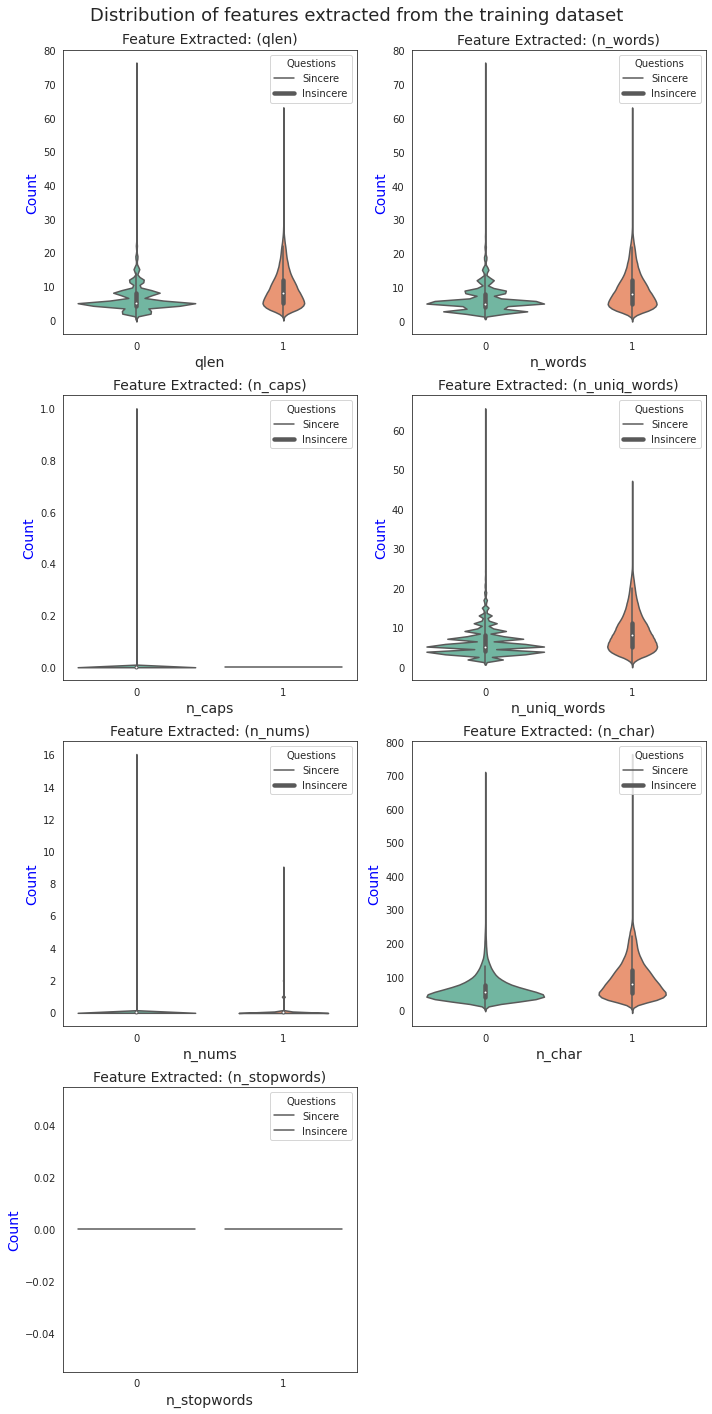

In [45]:
Cols = list(df_trn_eda.columns)

# Initialize the figure 
fig = plt.figure(figsize=(10, 20))
nrows = 4
ncols = 2
plt.suptitle("Distribution of features extracted from the training dataset", fontsize = 18)
for i in range(2, len(Cols)):
    col = Cols[i]
    plt.subplot(nrows, ncols, i-1)
    plt.title('Feature Extracted: ({})'.format(col), fontsize=14)
    ax = sns.violinplot(x="target", y=col, data=df_trn_eda, palette="Set2")
    ax.set_xlabel(xlabel=col, size=14)
    ax.set_ylabel(ylabel='Count' , color='b', size=14)
    plt.legend(title='Questions', loc='best', labels=['Sincere', 'Insincere'])
      
fig = ax.get_figure()
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# WORD CLOUD
To check the most prominent words in the training dataset

In [46]:
df_trn

,qid,target,question_text,Tokenized_text,lemm_text
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...,"[reply, comment, india, poor, fact, dont, unde...","[reply, comment, india, poor, fact, dont, unde..."
1,d49b3966070b27bf07fc,0,use transportation ancient india,"[use, transportation, ancient, india]","[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,0,important provisions obamacare,"[important, provisions, obamacare]","[important, provision, obamacare]"
3,cebea75faa47388edcf5,0,age finns master english today,"[age, finns, master, english, today]","[age, finn, master, english, today]"
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes..."
...,...,...,...,...,...
783668,8462d2ead608fe1dcf9b,0,causes lump back head,"[causes, lump, back, head]","[cause, lump, back, head]"
783669,12d225a4e28317c02151,0,standalone simple way,"[standalone, simple, way]","[standalone, simple, way]"
783670,03edc045cadbb11558dd,0,prevent low potassium pregnant,"[prevent, low, potassium, pregnant]","[prevent, low, potassium, pregnant]"
783671,c6fb7dc8d0b34160dbe4,0,like meet band imagine dragons,"[like, meet, band, imagine, dragons]","[like, meet, band, imagine, dragon]"


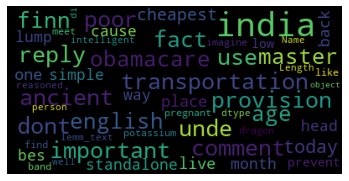

In [47]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_trn['lemm_text']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("df_trn_lemm_txt.png", dpi=900)

In [48]:
# Grouping and converting into dataframe based on the target value of 0 to be used for word cloud

df_trn_target_0 = pd.DataFrame(df_trn.groupby(['target']).get_group(0))
df_trn_target_0

,qid,target,question_text,Tokenized_text,lemm_text
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...,"[reply, comment, india, poor, fact, dont, unde...","[reply, comment, india, poor, fact, dont, unde..."
1,d49b3966070b27bf07fc,0,use transportation ancient india,"[use, transportation, ancient, india]","[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,0,important provisions obamacare,"[important, provisions, obamacare]","[important, provision, obamacare]"
3,cebea75faa47388edcf5,0,age finns master english today,"[age, finns, master, english, today]","[age, finn, master, english, today]"
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes..."
...,...,...,...,...,...
783667,af0e994fca341d876aee,0,shiksha mitra deserve salary rs ##### per mont...,"[shiksha, mitra, deserve, salary, rs, per, mon...","[shiksha, mitra, deserve, salary, r, per, mont..."
783668,8462d2ead608fe1dcf9b,0,causes lump back head,"[causes, lump, back, head]","[cause, lump, back, head]"
783669,12d225a4e28317c02151,0,standalone simple way,"[standalone, simple, way]","[standalone, simple, way]"
783670,03edc045cadbb11558dd,0,prevent low potassium pregnant,"[prevent, low, potassium, pregnant]","[prevent, low, potassium, pregnant]"


In [49]:
# Grouping and converting into dataframe based on the target value of 0 to be used for word cloud

df_trn_target_0 = pd.DataFrame(df_trn.groupby(['target']).get_group(0))
df_trn_target_0

,qid,target,question_text,Tokenized_text,lemm_text
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...,"[reply, comment, india, poor, fact, dont, unde...","[reply, comment, india, poor, fact, dont, unde..."
1,d49b3966070b27bf07fc,0,use transportation ancient india,"[use, transportation, ancient, india]","[use, transportation, ancient, india]"
2,6d5faa49380557c8ca7b,0,important provisions obamacare,"[important, provisions, obamacare]","[important, provision, obamacare]"
3,cebea75faa47388edcf5,0,age finns master english today,"[age, finns, master, english, today]","[age, finn, master, english, today]"
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes..."
...,...,...,...,...,...
783667,af0e994fca341d876aee,0,shiksha mitra deserve salary rs ##### per mont...,"[shiksha, mitra, deserve, salary, rs, per, mon...","[shiksha, mitra, deserve, salary, r, per, mont..."
783668,8462d2ead608fe1dcf9b,0,causes lump back head,"[causes, lump, back, head]","[cause, lump, back, head]"
783669,12d225a4e28317c02151,0,standalone simple way,"[standalone, simple, way]","[standalone, simple, way]"
783670,03edc045cadbb11558dd,0,prevent low potassium pregnant,"[prevent, low, potassium, pregnant]","[prevent, low, potassium, pregnant]"


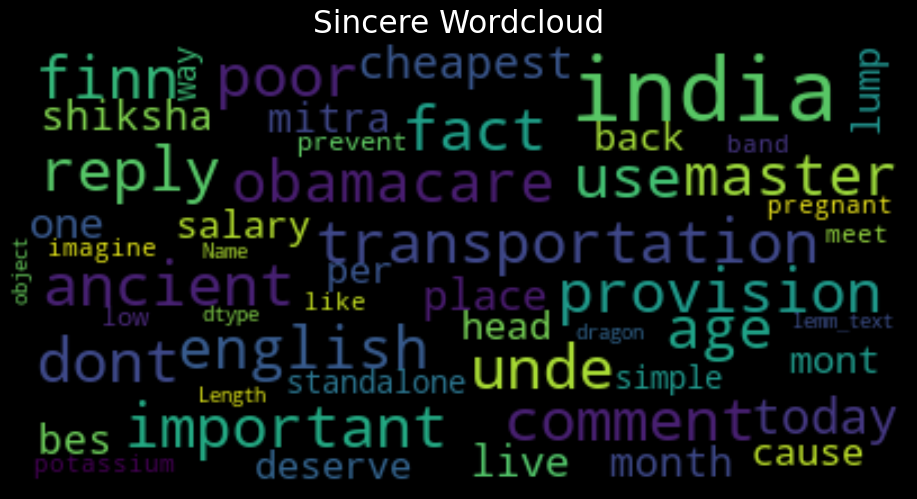

In [50]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_trn_target_0['lemm_text']))

print(wordcloud)
fig = plt.figure(figsize=(10,7), dpi=90, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Sincere Wordcloud", fontsize=25,color='w')
plt.tight_layout(pad=0)
plt.show()
fig.savefig("df_trn_Sincere.png", dpi=300)

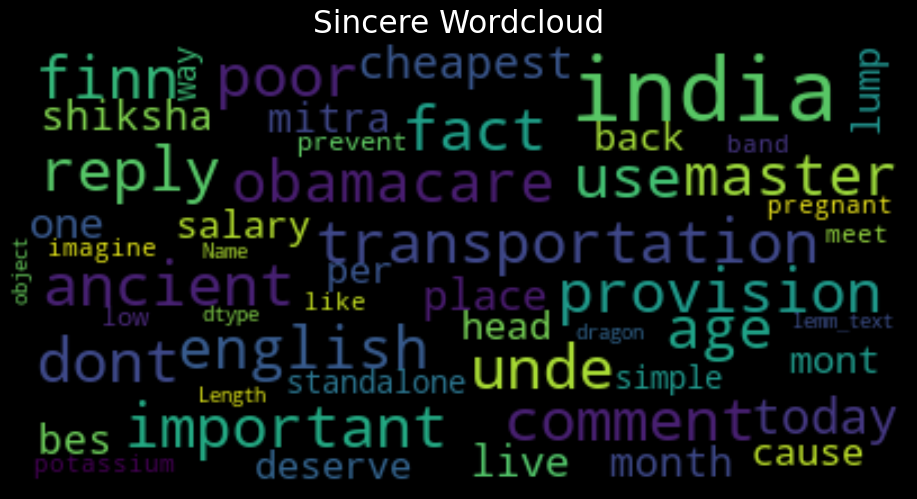

In [51]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_trn_target_0['lemm_text']))

print(wordcloud)
fig = plt.figure(figsize=(10,7), dpi=90, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Sincere Wordcloud", fontsize=25,color='w')
plt.tight_layout(pad=0)
plt.show()
fig.savefig("df_trn_Sincere.png", dpi=300)

# Advance NLP Text Processing:

**VECTORIZATION**

In [52]:
#Converting List to strings

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 
        

In [53]:
df_trn['lemm_str'] = df_trn['lemm_text'].apply(lambda x: listToString(x))

df_trn.head(5)
        

,qid,target,question_text,Tokenized_text,lemm_text,lemm_str
0,6f47b0f60633c2056455,0,reply comment india poor fact dont understand ...,"[reply, comment, india, poor, fact, dont, unde...","[reply, comment, india, poor, fact, dont, unde...",reply comment india poor fact dont understand ...
1,d49b3966070b27bf07fc,0,use transportation ancient india,"[use, transportation, ancient, india]","[use, transportation, ancient, india]",use transportation ancient india
2,6d5faa49380557c8ca7b,0,important provisions obamacare,"[important, provisions, obamacare]","[important, provision, obamacare]",important provision obamacare
3,cebea75faa47388edcf5,0,age finns master english today,"[age, finns, master, english, today]","[age, finn, master, english, today]",age finn master english today
4,2a7b76a679cadb0a016e,0,cheapest place live india one month best suits...,"[cheapest, place, live, india, one, month, bes...","[cheapest, place, live, india, one, month, bes...",cheapest place live india one month best suit ...


In [54]:
df_trn.to_csv('qiq_classification_lemm_str-v4.csv',index=False)

In [55]:
df_trn_2 = df_trn[["qid", "lemm_str", "target"]]
df_trn_2.head(5)

,qid,lemm_str,target
0,6f47b0f60633c2056455,reply comment india poor fact dont understand ...,0
1,d49b3966070b27bf07fc,use transportation ancient india,0
2,6d5faa49380557c8ca7b,important provision obamacare,0
3,cebea75faa47388edcf5,age finn master english today,0
4,2a7b76a679cadb0a016e,cheapest place live india one month best suit ...,0


Building a Baseline Model:

A baseline model is built using the (Logistic Regression) with TFIDF vectors

In [56]:
# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))

In [57]:
tfidf_vec.fit_transform(df_trn_2['lemm_str'].values.tolist() + qiq_tst['question_text'].values.tolist())

<1306122x8313568 sparse matrix of type '<class 'numpy.float64'>'
	with 18870410 stored elements in Compressed Sparse Row format>

In [58]:
train_tfidf = tfidf_vec.transform(df_trn_2['lemm_str'].values.tolist())
test_tfidf = tfidf_vec.transform(qiq_tst['question_text'].values.tolist())

In [59]:
train_tfidf

<783673x8313568 sparse matrix of type '<class 'numpy.float64'>'
	with 11070098 stored elements in Compressed Sparse Row format>

Building the model

In [60]:
train_y = df_trn_2["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([df_trn_2.shape[0]])
kf = model_selection.KFold(n_splits=7, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(df_trn_2):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


In [61]:
out_df = pd.DataFrame({"qid":qiq_tst["qid"].values})

In [62]:
out_df

,qid
0,f56a9a31974dc66186e8
1,d957c3758060f45da303
2,ad822d5abaedb9e247b9
3,4e979c23eeb6a4bd1f2e
4,333cc031262566b8da49
...,...
522444,e8e6aa5226f36c27fe41
522445,015fd068afcb9d0b4007
522446,9f0ef49eff6a3ff9e735
522447,d6b02f52f76dc4c22afd


In [63]:
pred_test_y_2 = (pred_test_y > 0.5).astype(int)
pred_test_y_2

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
out_df['target'] = pred_test_y_2

In [65]:
out_df

,qid,target
0,f56a9a31974dc66186e8,0
1,d957c3758060f45da303,0
2,ad822d5abaedb9e247b9,0
3,4e979c23eeb6a4bd1f2e,0
4,333cc031262566b8da49,0
...,...,...
522444,e8e6aa5226f36c27fe41,0
522445,015fd068afcb9d0b4007,0
522446,9f0ef49eff6a3ff9e735,0
522447,d6b02f52f76dc4c22afd,0


In [66]:
out_df.shape

(522449, 2)

In [67]:
out_df.to_csv("Outliers_submission-1.csv", index=False)

In [68]:
cv_scores

[0.13259597066034493]

In [69]:
pred_test_y

array([0.00810775, 0.00647814, 0.02855098, ..., 0.00821889, 0.09421464,
       0.0399396 ])

The best threshold based on validation sample.

In [70]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))

F1 score at threshold 0.1 is 0.5429948686051936
F1 score at threshold 0.11 is 0.5510933102403117
F1 score at threshold 0.12 is 0.5572094590799304
F1 score at threshold 0.13 is 0.5605858081013542
F1 score at threshold 0.14 is 0.5641148325358851
F1 score at threshold 0.15 is 0.5669146124054835
F1 score at threshold 0.16 is 0.5669868554095044
F1 score at threshold 0.17 is 0.5661793246215552
F1 score at threshold 0.18 is 0.565855593758265
F1 score at threshold 0.19 is 0.5641407307171854
F1 score at threshold 0.2 is 0.5618724465064747
